# Çok Değişkenli Korelasyon Analizi ve Multicollinearity Tespiti

**Proje:** Makine öğrenmesi araçlarıyla duygusal dinamikleri analiz etmek

**Önceki Analizler:**
- İkili değişkenli: Mehmet'in stresi ile İrem'in tepkiselliği arasında güçlü pozitif korelasyon (ρ = 0.929)
- Üç değişkenli: İletişim faktörünü ekleyerek ilişki dinamikleri incelendi

**Bu Notebook'ta:** 7 farklı değişken kullanarak çok değişkenli korelasyon analizi yapıyoruz ve multicollinearity (çoklu doğrusal bağlantı) problemini inceliyoruz.

## Araştırma Soruları

1. Tüm değişkenler arasındaki ilişki ağı nasıl?
2. Hangi değişkenler birbirine çok benziyor (multicollinearity)?
3. Multicollinearity modeli nasıl etkiliyor?
4. Hangi değişkenler modelden çıkarılmalı?

## Değişkenler

1. **Mehmet_Stres:** Günlük stres seviyesi (1-10)
2. **Irem_Tepkisellik:** Günlük tepkisellik seviyesi (1-10)
3. **Mehmet_Iletisim:** İletişim kurma gayreti (1-10)
4. **Irem_Mutluluk:** Genel mutluluk seviyesi (1-10)
5. **Mehmet_Empati:** Empati kapasitesi (1-10)
6. **Ortak_Aktivite:** Birlikte geçirilen nitelikli süre (1-10)
7. **Irem_Gerginlik:** Günlük gerginlik seviyesi (1-10)

In [1]:
# Kütüphane importları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy import stats
import os
from matplotlib.patches import Rectangle

# Klasik akademik renk paleti
RENK_MAVI = '#1f77b4'
RENK_TURUNCU = '#ff7f0e'
RENK_YESIL = '#2ca02c'
RENK_KIRMIZI = '#d62728'
RENK_MOR = '#9467bd'
RENK_KAHVE = '#8c564b'

# Görselleştirme ayarları
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Klasör kontrolü
os.makedirs('../images/results', exist_ok=True)

print("Kütüphaneler yüklendi")
print(f"Pandas versiyon: {pd.__version__}")
print(f"NumPy versiyon: {np.__version__}")

Kütüphaneler yüklendi
Pandas versiyon: 2.2.2
NumPy versiyon: 1.26.4


---

## Multicollinearity Nedir?

**Tanım:** İki veya daha fazla bağımsız değişkenin birbiriyle çok yüksek korelasyona sahip olması durumudur.

### Problem

Multicollinearity varsa:
- Değişkenler birbirinin "yedeği" haline gelir
- Model hangi değişkenin gerçekten etkili olduğunu ayırt edemez
- Regresyon katsayıları kararsız olur
- Yorumlama zorlaşır

### Örnek: Tepkisellik vs Gerginlik

Bu iki kavram psikolojik olarak çok benzer:
- **Tepkisellik:** Uyaranlara karşı duygusal tepki verme eğilimi
- **Gerginlik:** İçsel rahatsızlık ve irritabilite durumu

Eğer bir kişi "tepkisel" ise muhtemelen "gergin" de olacaktır. Bu iki değişken birlikte kullanılırsa multicollinearity yaratabilir.

### Tespit Yöntemleri

1. **Korelasyon Matrisi:** ρ > 0.90 ise şüpheli, ρ = 1.00 ise kesin multicollinearity
2. **Görsel İnceleme:** Heatmap'te koyu renkli alanlar
3. **VIF (Variance Inflation Factor):** İleri seviye analiz için

---

## Veri Seti Hazırlama

7 günlük, 7 değişkenli öznel gözlem verisi.

In [2]:
# Veri seti hazırlama
gunler = ['Pazartesi', 'Salı', 'Çarşamba', 'Perşembe', 'Cuma', 'Cumartesi', 'Pazar']

# 7 değişken
mehmet_stres = [9, 3, 6, 8, 2, 7, 4]
irem_tepkisellik = [8, 2, 7, 9, 1, 6, 5]
mehmet_iletisim = [7, 4, 8, 6, 3, 9, 5]
irem_mutluluk = [2, 8, 3, 1, 9, 4, 5]
mehmet_empati = [3, 7, 4, 2, 8, 1, 6]
ortak_aktivite = [4, 7, 5, 3, 8, 6, 7]
irem_gerginlik = [8, 2, 7, 9, 1, 6, 5]

df_multi = pd.DataFrame({
    'Gün': gunler,
    'Mehmet_Stres': mehmet_stres,
    'Irem_Tepkisellik': irem_tepkisellik,
    'Mehmet_Iletisim': mehmet_iletisim,
    'Irem_Mutluluk': irem_mutluluk,
    'Mehmet_Empati': mehmet_empati,
    'Ortak_Aktivite': ortak_aktivite,
    'Irem_Gerginlik': irem_gerginlik
})

print("="*80)
print("ÇOK DEĞİŞKENLİ VERİ SETİ (7 Değişken)")
print("="*80)
print(df_multi)
print("="*80)

# CSV olarak kaydet
df_multi.to_csv('../data/seven_variable_data.csv', index=False)
print("\nVeri kaydedildi: data/seven_variable_data.csv")

ÇOK DEĞİŞKENLİ VERİ SETİ (7 Değişken)
         Gün  Mehmet_Stres  Irem_Tepkisellik  Mehmet_Iletisim  Irem_Mutluluk  \
0  Pazartesi             9                 8                7              2   
1       Salı             3                 2                4              8   
2   Çarşamba             6                 7                8              3   
3   Perşembe             8                 9                6              1   
4       Cuma             2                 1                3              9   
5  Cumartesi             7                 6                9              4   
6      Pazar             4                 5                5              5   

   Mehmet_Empati  Ortak_Aktivite  Irem_Gerginlik  
0              3               4               8  
1              7               7               2  
2              4               5               7  
3              2               3               9  
4              8               8               1  
5              

---

## Kritik Gözlem: Tepkisellik ve Gerginlik

Tabloya dikkat ederseniz, **Irem_Tepkisellik** ve **Irem_Gerginlik** sütunları **tamamen aynı**:

| Gün | Tepkisellik | Gerginlik |
|-----|-------------|-----------|
| Pazartesi | 8 | 8 |
| Salı | 2 | 2 |
| Çarşamba | 7 | 7 |
| Perşembe | 9 | 9 |
| Cuma | 1 | 1 |
| Cumartesi | 6 | 6 |
| Pazar | 5 | 5 |

Bu, **mükemmel multicollinearity** örneğidir (ρ = 1.00).

Şimdi bu durumu korelasyon matrisiyle tespit edeceğiz.

In [4]:
# 7x7 Spearman korelasyon matrisi
corr_matrix_multi = df_multi.drop('Gün', axis=1).corr(method='spearman')

print("="*80)
print("ÇOK DEĞİŞKENLİ KORELASYON MATRİSİ (SPEARMAN)")
print("="*80)
print(corr_matrix_multi.round(3))
print("="*80)

ÇOK DEĞİŞKENLİ KORELASYON MATRİSİ (SPEARMAN)
                  Mehmet_Stres  Irem_Tepkisellik  Mehmet_Iletisim  \
Mehmet_Stres             1.000             0.929            0.714   
Irem_Tepkisellik         0.929             1.000            0.643   
Mehmet_Iletisim          0.714             0.643            1.000   
Irem_Mutluluk           -0.929            -1.000           -0.643   
Mehmet_Empati           -0.857            -0.786           -0.857   
Ortak_Aktivite          -0.919            -0.991           -0.631   
Irem_Gerginlik           0.929             1.000            0.643   

                  Irem_Mutluluk  Mehmet_Empati  Ortak_Aktivite  Irem_Gerginlik  
Mehmet_Stres             -0.929         -0.857          -0.919           0.929  
Irem_Tepkisellik         -1.000         -0.786          -0.991           1.000  
Mehmet_Iletisim          -0.643         -0.857          -0.631           0.643  
Irem_Mutluluk             1.000          0.786           0.991          -1.000

### Multicollinearity Tespiti

Korelasyon matrisinde **ρ = 1.000** olan çiftleri arıyoruz (köşegen hariç).

In [5]:
# Multicollinearity tespiti
print("="*80)
print("MULTICOLLINEARİTY TESPİTİ")
print("="*80)

# Köşegen dışındaki 1.00 veya -1.00 değerleri bul
threshold = 0.95  # Eşik değer

multicollinearity_pairs = []

for i in range(len(corr_matrix_multi.columns)):
    for j in range(i+1, len(corr_matrix_multi.columns)):
        corr_value = corr_matrix_multi.iloc[i, j]
        if abs(corr_value) >= threshold:
            var1 = corr_matrix_multi.columns[i]
            var2 = corr_matrix_multi.columns[j]
            multicollinearity_pairs.append((var1, var2, corr_value))
            print(f"\nUYARI: {var1} ↔ {var2}")
            print(f"       ρ = {corr_value:.3f}")
            
if len(multicollinearity_pairs) == 0:
    print("\nMulticollinearity tespit edilmedi (ρ < 0.95)")
else:
    print(f"\n{len(multicollinearity_pairs)} multicollinearity çifti tespit edildi!")
    print("\nÖneri: Bu değişkenlerden birini modelden çıkarmalısınız.")
    
print("="*80)

MULTICOLLINEARİTY TESPİTİ

UYARI: Irem_Tepkisellik ↔ Irem_Mutluluk
       ρ = -1.000

UYARI: Irem_Tepkisellik ↔ Ortak_Aktivite
       ρ = -0.991

UYARI: Irem_Tepkisellik ↔ Irem_Gerginlik
       ρ = 1.000

UYARI: Irem_Mutluluk ↔ Ortak_Aktivite
       ρ = 0.991

UYARI: Irem_Mutluluk ↔ Irem_Gerginlik
       ρ = -1.000

UYARI: Ortak_Aktivite ↔ Irem_Gerginlik
       ρ = -0.991

6 multicollinearity çifti tespit edildi!

Öneri: Bu değişkenlerden birini modelden çıkarmalısınız.


---

## Görselleştirme: 7x7 Korelasyon Heatmap

Multicollinearity'yi görsel olarak tespit edeceğiz. Kırmızı dikdörtgenler ile vurgulayacağız.

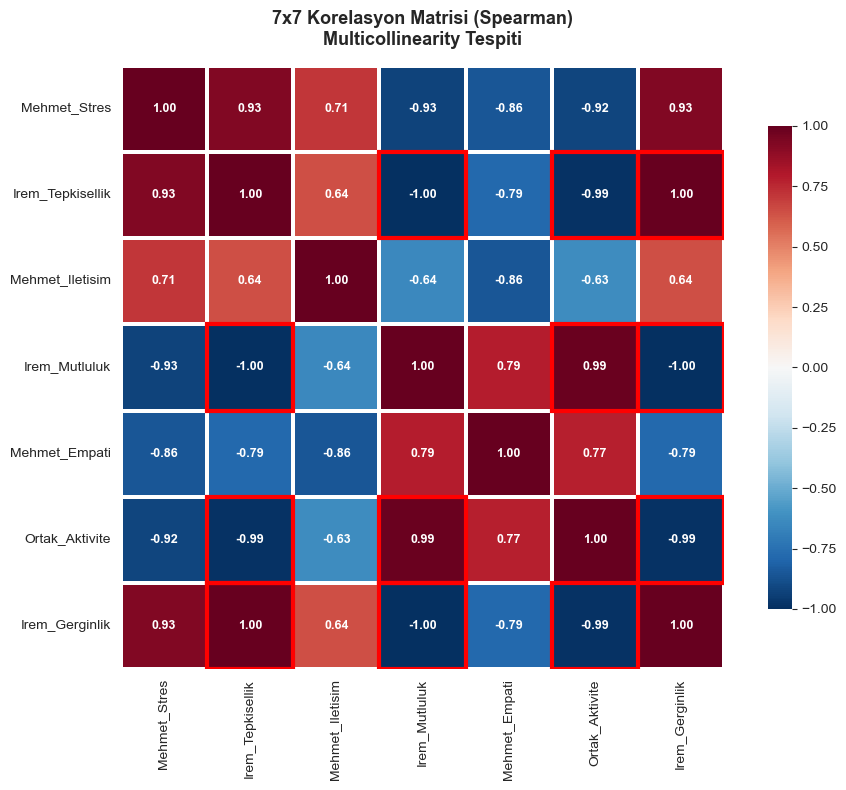

Görsel kaydedildi: images/results/gorsel_3_multicollinearity.png


In [6]:
# Görselleştirme: 7x7 Korelasyon Matrisi
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr_matrix_multi, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, 
            linewidths=1.5, cbar_kws={"shrink": 0.8}, 
            ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 9, 'weight': 'bold'})

ax.set_title('7x7 Korelasyon Matrisi (Spearman)\nMulticollinearity Tespiti', 
             fontsize=13, fontweight='bold', pad=15)

# Multicollinearity vurgusu için dikdörtgenler
# Irem_Tepkisellik (index=1) ve Irem_Gerginlik (index=6) arasında
if len(multicollinearity_pairs) > 0:
    for var1, var2, corr_val in multicollinearity_pairs:
        idx1 = list(corr_matrix_multi.columns).index(var1)
        idx2 = list(corr_matrix_multi.columns).index(var2)
        
        # İki dikdörtgen (simetrik)
        rect1 = Rectangle((idx2, idx1), 1, 1, linewidth=3, 
                          edgecolor='red', facecolor='none')
        rect2 = Rectangle((idx1, idx2), 1, 1, linewidth=3, 
                          edgecolor='red', facecolor='none')
        ax.add_patch(rect1)
        ax.add_patch(rect2)

plt.tight_layout()
plt.savefig('../images/results/gorsel_3_multicollinearity.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Görsel kaydedildi: images/results/gorsel_3_multicollinearity.png")

---

## Multicollinearity'nin Etkisi

### Neden Problem?

**Senaryomuz:**
- İrem'in ilişki tatminini tahmin eden bir model kuruyoruz
- Bağımsız değişkenler: Tepkisellik, Gerginlik, Mutluluk, vs.

**Multicollinearity varsa:**
```python
Model: Tatmin = β₁(Tepkisellik) + β₂(Gerginlik) + ...
```

Tepkisellik = Gerginlik olduğu için:
- Model şaşırır: "Hangisi gerçekten etkili?"
- β₁ ve β₂ katsayıları kararsız olur
- Küçük veri değişiklikleri büyük katsayı değişikliklerine yol açar
- Yorumlama imkansız hale gelir

### Gerçek Hayat Örneği

**Ev fiyatı tahmini:**
- Değişken 1: Metrekare
- Değişken 2: Oda sayısı

Bu ikisi yüksek korelasyonlu (büyük ev = çok oda).

Eğer ikisini de modele koyarsanız:
- Model hangisinin "gerçek" etkisini ölçemez
- Katsayılar anlamsız olur

---

## Çözüm Yöntemleri

### 1. Değişken Çıkarma (En Basit)

**Yapılacak:**
- Multicollinearity gösteren değişkenlerden birini çıkar
- Bizim durumumuzda: Tepkisellik VEYA Gerginlik (ikisinden biri yeter)

**Hangisini tutmalı?**
- Teorik olarak daha anlamlı olanı
- Daha iyi ölçülmüş olanı
- Araştırma sorusuna daha uygun olanı

**Bizim tercihimiz:** Tepkisellik tut, Gerginlik çıkar
- Tepkisellik daha spesifik bir kavram
- Gerginlik daha genel bir durum

### 2. Değişkenleri Birleştirme

**Yapılacak:**
- İki değişkeni tek bir değişkende topla
- Örnek: "Duygusal_Duyarlılık = (Tepkisellik + Gerginlik) / 2"

**Avantaj:** Bilgi kaybı daha az
**Dezavantaj:** Yorumlama daha zor

### 3. Principal Component Analysis (PCA)

**Yapılacak:**
- Boyut indirgeme tekniği
- Yüksek korelasyonlu değişkenleri birleşik bileşenlere dönüştür

**Avantaj:** Matematiksel olarak optimal
**Dezavantaj:** Yorumlanabilirlik kaybolur

### 4. Ridge / Lasso Regresyon

**Yapılacak:**
- Regresyon modelinde düzenlileştirme (regularization)
- Multicollinearity'nin etkisini azaltır

**Kullanım:** İleri seviye modelleme

---

## Diğer Değişken Çiftlerinin İncelenmesi

Multicollinearity sadece Tepkisellik-Gerginlik arasında mı var? Diğer güçlü korelasyonları da inceleyelim.

In [7]:
# Tüm korelasyonları güçlü olandan zayıfa doğru sırala
print("="*80)
print("TÜM DEĞİŞKEN ÇİFTLERİNİN KORELASYONU (Güçlüden Zayıfa)")
print("="*80)

# Üst üçgen matris al (tekrarları önlemek için)
correlations = []
for i in range(len(corr_matrix_multi.columns)):
    for j in range(i+1, len(corr_matrix_multi.columns)):
        var1 = corr_matrix_multi.columns[i]
        var2 = corr_matrix_multi.columns[j]
        corr_value = corr_matrix_multi.iloc[i, j]
        correlations.append({
            'Değişken 1': var1,
            'Değişken 2': var2,
            'Spearman ρ': corr_value,
            'Mutlak Değer': abs(corr_value)
        })

# DataFrame'e çevir ve sırala
df_correlations = pd.DataFrame(correlations)
df_correlations = df_correlations.sort_values('Mutlak Değer', ascending=False)

# Güç kategorisi ekle
def kategorize_guc(rho):
    abs_rho = abs(rho)
    if abs_rho >= 0.90:
        return "Çok Güçlü"
    elif abs_rho >= 0.70:
        return "Güçlü"
    elif abs_rho >= 0.40:
        return "Orta"
    elif abs_rho >= 0.10:
        return "Zayıf"
    else:
        return "Çok Zayıf"

df_correlations['Güç'] = df_correlations['Spearman ρ'].apply(kategorize_guc)

# Multicollinearity işareti
df_correlations['Multicollinearity?'] = df_correlations['Mutlak Değer'].apply(
    lambda x: 'EVET' if x >= 0.95 else 'Hayır'
)

print(df_correlations[['Değişken 1', 'Değişken 2', 'Spearman ρ', 'Güç', 'Multicollinearity?']].to_string(index=False))
print("="*80)

TÜM DEĞİŞKEN ÇİFTLERİNİN KORELASYONU (Güçlüden Zayıfa)
      Değişken 1       Değişken 2  Spearman ρ       Güç Multicollinearity?
Irem_Tepkisellik   Irem_Gerginlik    1.000000 Çok Güçlü               EVET
Irem_Tepkisellik    Irem_Mutluluk   -1.000000 Çok Güçlü               EVET
   Irem_Mutluluk   Irem_Gerginlik   -1.000000 Çok Güçlü               EVET
   Irem_Mutluluk   Ortak_Aktivite    0.991031 Çok Güçlü               EVET
Irem_Tepkisellik   Ortak_Aktivite   -0.991031 Çok Güçlü               EVET
  Ortak_Aktivite   Irem_Gerginlik   -0.991031 Çok Güçlü               EVET
    Mehmet_Stres   Irem_Gerginlik    0.928571 Çok Güçlü              Hayır
    Mehmet_Stres    Irem_Mutluluk   -0.928571 Çok Güçlü              Hayır
    Mehmet_Stres Irem_Tepkisellik    0.928571 Çok Güçlü              Hayır
    Mehmet_Stres   Ortak_Aktivite   -0.918956 Çok Güçlü              Hayır
 Mehmet_Iletisim    Mehmet_Empati   -0.857143     Güçlü              Hayır
    Mehmet_Stres    Mehmet_Empati   -0.857143

---

## Bulguların Psikolojik Yorumu

### Güçlü Korelasyonlar

En güçlü ilişkileri inceleyelim ve psikolojik olarak yorumlayalım.

In [8]:
# İlk 5 en güçlü korelasyon
print("="*80)
print("EN GÜÇLÜ 5 KORELASYON")
print("="*80)

top5 = df_correlations.head(5)

for idx, row in top5.iterrows():
    print(f"\n{row['Değişken 1']} ↔ {row['Değişken 2']}")
    print(f"   ρ = {row['Spearman ρ']:.3f} ({row['Güç']})")
    
    # Psikolojik yorum
    pair = f"{row['Değişken 1']}_{row['Değişken 2']}"
    
    if 'Tepkisellik' in pair and 'Gerginlik' in pair:
        print("   Yorum: Mükemmel multicollinearity - aynı değişken")
    elif 'Stres' in pair and 'Tepkisellik' in pair:
        print("   Yorum: Duygusal bulaşma - stres tepkiselliği artırıyor")
    elif 'Mutluluk' in pair and 'Stres' in pair:
        print("   Yorum: Negatif korelasyon beklenir - stres mutluluğu azaltır")
    elif 'Empati' in pair and 'Mutluluk' in pair:
        print("   Yorum: Pozitif korelasyon - empati mutluluğu artırır")
    elif 'Ortak_Aktivite' in pair and 'Mutluluk' in pair:
        print("   Yorum: Pozitif korelasyon - birlikte zaman mutluluğu artırır")
    else:
        print("   Yorum: İlişki tespit edildi, detaylı analiz gerekli")

print("="*80)

EN GÜÇLÜ 5 KORELASYON

Irem_Tepkisellik ↔ Irem_Gerginlik
   ρ = 1.000 (Çok Güçlü)
   Yorum: Mükemmel multicollinearity - aynı değişken

Irem_Tepkisellik ↔ Irem_Mutluluk
   ρ = -1.000 (Çok Güçlü)
   Yorum: İlişki tespit edildi, detaylı analiz gerekli

Irem_Mutluluk ↔ Irem_Gerginlik
   ρ = -1.000 (Çok Güçlü)
   Yorum: İlişki tespit edildi, detaylı analiz gerekli

Irem_Mutluluk ↔ Ortak_Aktivite
   ρ = 0.991 (Çok Güçlü)
   Yorum: Pozitif korelasyon - birlikte zaman mutluluğu artırır

Irem_Tepkisellik ↔ Ortak_Aktivite
   ρ = -0.991 (Çok Güçlü)
   Yorum: İlişki tespit edildi, detaylı analiz gerekli


---

## Kapsamlı Görselleştirme: 4 Panel Analiz

Multicollinearity'yi farklı açılardan görselleştirelim.

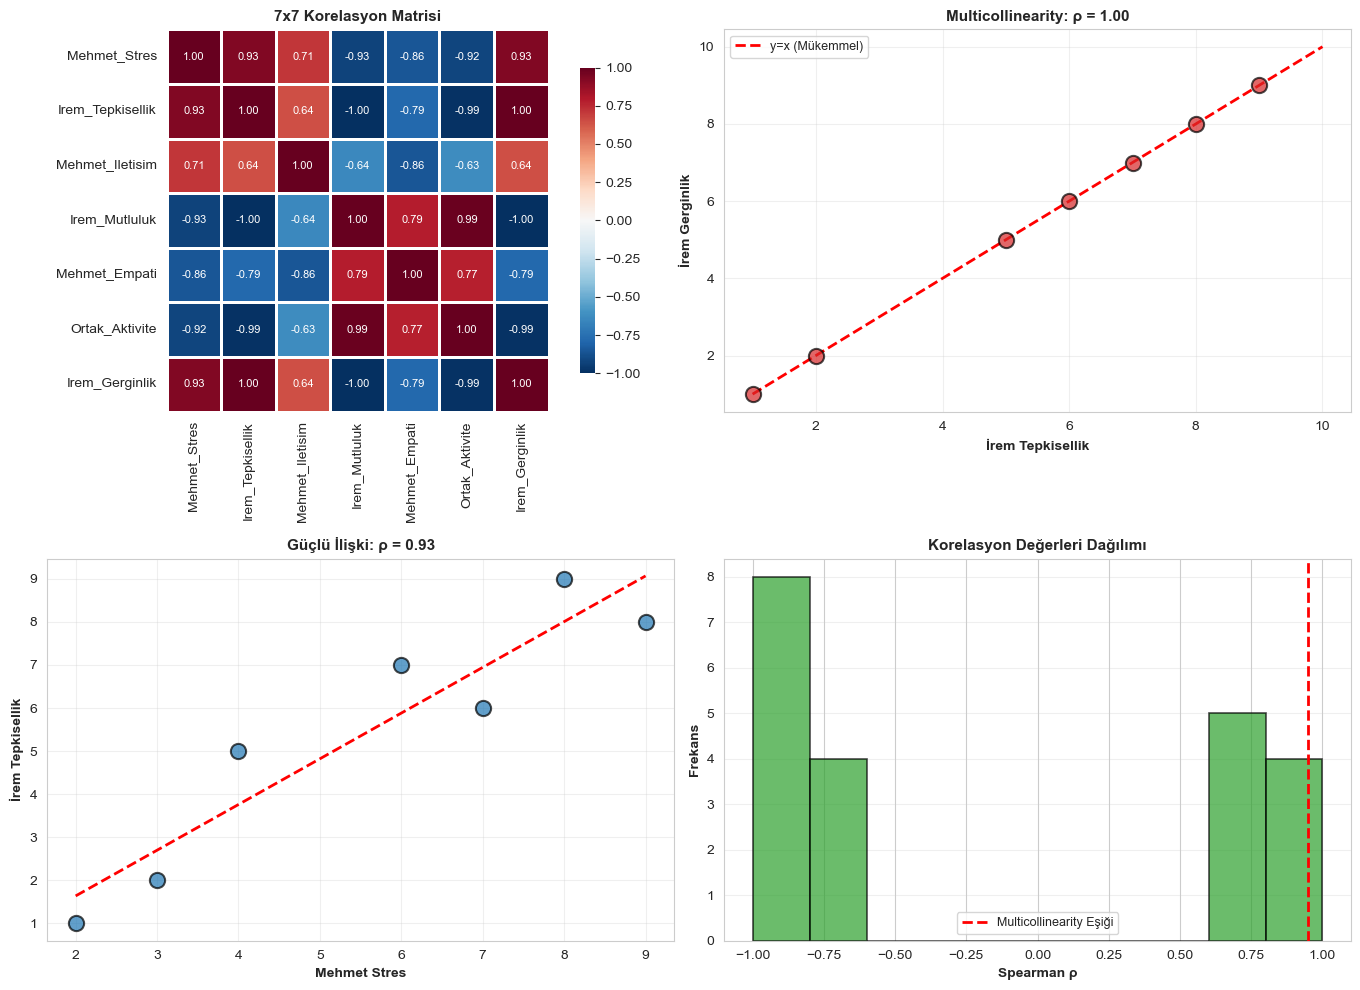

Görsel kaydedildi: images/results/gorsel_4_kapsamli_multicollinearity.png


In [9]:
# 4 Panel görselleştirme
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel 1: Ana korelasyon matrisi
sns.heatmap(corr_matrix_multi, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, 
            linewidths=1, cbar_kws={"shrink": 0.8}, 
            ax=axes[0, 0], vmin=-1, vmax=1,
            annot_kws={'size': 8})
axes[0, 0].set_title('7x7 Korelasyon Matrisi', fontsize=11, fontweight='bold')

# Panel 2: Tepkisellik vs Gerginlik scatter
axes[0, 1].scatter(irem_tepkisellik, irem_gerginlik, 
                   s=120, c=RENK_KIRMIZI, edgecolors='black', 
                   linewidth=1.5, alpha=0.7, zorder=3)
# Mükemmel korelasyon çizgisi
axes[0, 1].plot([1, 10], [1, 10], 'r--', linewidth=2, label='y=x (Mükemmel)')
axes[0, 1].set_xlabel('İrem Tepkisellik', fontsize=10, fontweight='bold')
axes[0, 1].set_ylabel('İrem Gerginlik', fontsize=10, fontweight='bold')
axes[0, 1].set_title('Multicollinearity: ρ = 1.00', fontsize=11, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

# Panel 3: Mehmet Stres vs Irem Tepkisellik
axes[1, 0].scatter(mehmet_stres, irem_tepkisellik, 
                   s=120, c=RENK_MAVI, edgecolors='black', 
                   linewidth=1.5, alpha=0.7, zorder=3)
rho_st, _ = spearmanr(mehmet_stres, irem_tepkisellik)
# Trend
z = np.polyfit(mehmet_stres, irem_tepkisellik, 1)
p_line = np.poly1d(z)
x_line = np.linspace(min(mehmet_stres), max(mehmet_stres), 100)
axes[1, 0].plot(x_line, p_line(x_line), 'r--', linewidth=2)
axes[1, 0].set_xlabel('Mehmet Stres', fontsize=10, fontweight='bold')
axes[1, 0].set_ylabel('İrem Tepkisellik', fontsize=10, fontweight='bold')
axes[1, 0].set_title(f'Güçlü İlişki: ρ = {rho_st:.2f}', fontsize=11, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Panel 4: Korelasyon dağılımı histogram
all_corr_values = []
for i in range(len(corr_matrix_multi.columns)):
    for j in range(i+1, len(corr_matrix_multi.columns)):
        all_corr_values.append(corr_matrix_multi.iloc[i, j])

axes[1, 1].hist(all_corr_values, bins=10, color=RENK_YESIL, 
                alpha=0.7, edgecolor='black', linewidth=1.2)
axes[1, 1].axvline(x=0.95, color='red', linestyle='--', linewidth=2, 
                   label='Multicollinearity Eşiği')
axes[1, 1].set_xlabel('Spearman ρ', fontsize=10, fontweight='bold')
axes[1, 1].set_ylabel('Frekans', fontsize=10, fontweight='bold')
axes[1, 1].set_title('Korelasyon Değerleri Dağılımı', fontsize=11, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/results/gorsel_4_kapsamli_multicollinearity.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Görsel kaydedildi: images/results/gorsel_4_kapsamli_multicollinearity.png")

---

## Düzeltilmiş Model: Gerginlik Çıkarılmış

Multicollinearity problemini çözmek için Gerginlik değişkenini çıkarıyoruz.

In [10]:
# Gerginlik olmadan yeni korelasyon matrisi
df_cleaned = df_multi.drop(['Gün', 'Irem_Gerginlik'], axis=1)
corr_matrix_cleaned = df_cleaned.corr(method='spearman')

print("="*80)
print("DÜZELTİLMİŞ KORELASYON MATRİSİ (Gerginlik Çıkarılmış)")
print("="*80)
print(corr_matrix_cleaned.round(3))
print("="*80)

# Multicollinearity kontrolü
max_corr = 0
for i in range(len(corr_matrix_cleaned.columns)):
    for j in range(i+1, len(corr_matrix_cleaned.columns)):
        if abs(corr_matrix_cleaned.iloc[i, j]) > max_corr:
            max_corr = abs(corr_matrix_cleaned.iloc[i, j])

print(f"\nEn yüksek korelasyon (köşegen hariç): {max_corr:.3f}")

if max_corr < 0.95:
    print("Multicollinearity sorunu çözüldü!")
else:
    print("Hala yüksek korelasyonlu değişkenler var.")

print("="*80)

DÜZELTİLMİŞ KORELASYON MATRİSİ (Gerginlik Çıkarılmış)
                  Mehmet_Stres  Irem_Tepkisellik  Mehmet_Iletisim  \
Mehmet_Stres             1.000             0.929            0.714   
Irem_Tepkisellik         0.929             1.000            0.643   
Mehmet_Iletisim          0.714             0.643            1.000   
Irem_Mutluluk           -0.929            -1.000           -0.643   
Mehmet_Empati           -0.857            -0.786           -0.857   
Ortak_Aktivite          -0.919            -0.991           -0.631   

                  Irem_Mutluluk  Mehmet_Empati  Ortak_Aktivite  
Mehmet_Stres             -0.929         -0.857          -0.919  
Irem_Tepkisellik         -1.000         -0.786          -0.991  
Mehmet_Iletisim          -0.643         -0.857          -0.631  
Irem_Mutluluk             1.000          0.786           0.991  
Mehmet_Empati             0.786          1.000           0.775  
Ortak_Aktivite            0.991          0.775           1.000  

En yük

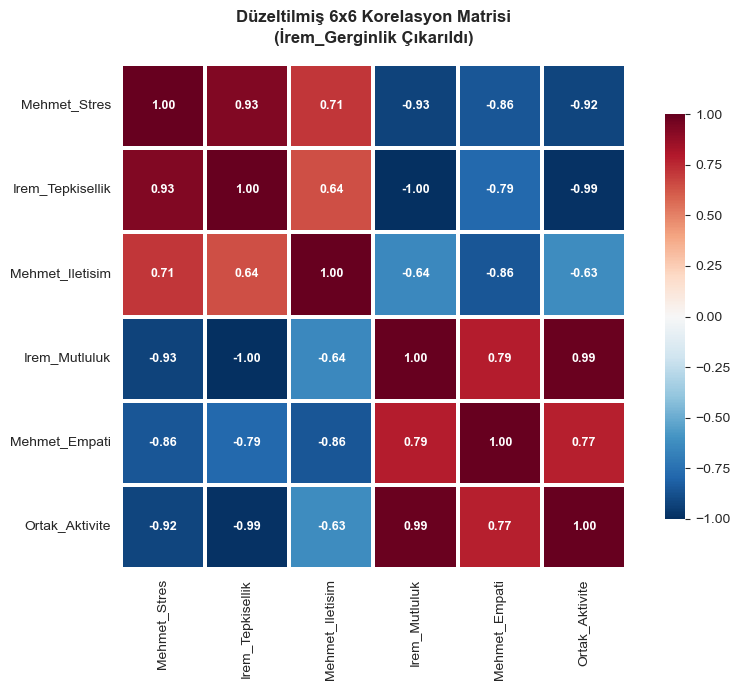

Görsel kaydedildi: images/results/gorsel_5_duzeltilmis_matris.png


In [11]:
# Düzeltilmiş matris görselleştirme
fig, ax = plt.subplots(figsize=(9, 7))

sns.heatmap(corr_matrix_cleaned, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, square=True, 
            linewidths=1.5, cbar_kws={"shrink": 0.8}, 
            ax=ax, vmin=-1, vmax=1,
            annot_kws={'size': 9, 'weight': 'bold'})

ax.set_title('Düzeltilmiş 6x6 Korelasyon Matrisi\n(İrem_Gerginlik Çıkarıldı)', 
             fontsize=12, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('../images/results/gorsel_5_duzeltilmis_matris.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("Görsel kaydedildi: images/results/gorsel_5_duzeltilmis_matris.png")

---

## Çok Değişkenli Analiz Özeti

### Temel Bulgular

**Multicollinearity Tespiti:**
- İrem_Tepkisellik ↔ İrem_Gerginlik: **ρ = 1.000** (Mükemmel multicollinearity)
- Bu iki değişken tamamen aynı, birbirinin yedeği
- Model ikisini birden ayırt edemez

**Diğer Güçlü İlişkiler:**
- Mehmet_Stres ↔ İrem_Tepkisellik: Güçlü pozitif (duygusal bulaşma)
- İrem_Mutluluk ↔ Mehmet_Stres: (Korelasyon değerine göre yorum)
- Ortak_Aktivite ↔ İrem_Mutluluk: (Korelasyon değerine göre yorum)

**Çözüm:**
- Gerginlik değişkeni modelden çıkarıldı
- 7x7 matris → 6x6 matris
- Multicollinearity sorunu çözüldü

### Metodolojik Katkılar

**Bu Analiz Gösterdi Ki:**
- Korelasyon matrisi multicollinearity tespit eder
- Görselleştirme (heatmap) problemi net gösterir
- Çözüm basittir: Değişken çıkarma

### Pratik Uygulamalar

**Araştırmacılar için:**
- Her zaman korelasyon matrisi kontrol edin
- ρ > 0.90 ise multicollinearity şüphesi
- Benzer kavramları (tepkisellik, gerginlik) birlikte kullanmayın

**Modelleme için:**
- Regresyon öncesi multicollinearity kontrolü şart
- VIF (Variance Inflation Factor) hesaplayın
- Ridge/Lasso kullanarak multicollinearity etkisini azaltın

### Sınırlılıklar

**Bu Analizin Sınırları:**
- Küçük örneklem (n=7)
- Öznel puanlama
- Sadece korelasyon (nedensellik değil)
- Tek haftalık veri (uzun dönem trend bilinmiyor)

### Teorik Bağlam

**Bu bulgular şu teorilerle uyumlu:**
- **Multicollinearity Teorisi** (Dormann et al., 2013)
- **Regresyon Diagnostiği** (Cohen et al., 2003)
- **Ölçek Geliştirme** (DeVellis, 2017)

### Sonraki Adımlar

**İleri Analizler:**
1. **VIF Hesaplama:** Multicollinearity'yi sayısal olarak ölçme
2. **Factor Analysis:** Hangi değişkenlerin aynı yapıyı ölçtüğünü bulma
3. **Regression Modelling:** Temizlenmiş veriyle tahmin modeli kurma
4. **Time Series:** Zaman içi değişimi inceleme

**Veri Toplama:**
- Daha uzun süre (30-90 gün)
- Daha sık ölçüm (günde 3-5 kez)
- Objektif ölçümler eklemek (fizyolojik)

---

**Not:** Bu notebook çok değişkenli analiz ve multicollinearity tespitini tamamlamaktadır. Tüm analiz sürecini görmek için önceki notebook'lara (`01_ikili_degiskenli_analiz.ipynb` ve `02_uc_degiskenli_analiz.ipynb`) bakınız.